In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
airline = pd.read_excel("C:\\Users\\jhishna2022\\Downloads\\Airlines+Data.xlsx")
airline

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


## EDA

In [3]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [4]:
airline.isnull().sum()

Month         0
Passengers    0
dtype: int64

### Visualization

#### Lineplot

<AxesSubplot:xlabel='Month', ylabel='Passengers'>

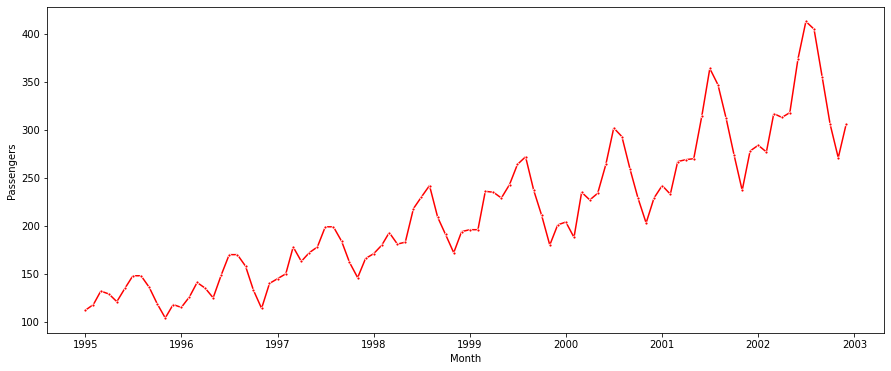

In [8]:
plt.figure(figsize=(15,6))
#plt.xlabel("Year")
#plt.ylabel("Number of air passengers")
#ax = plt.axes()
#ax.set_facecolor("black")
#plt.plot(airline['Passengers'], color = 'yellow', linewidth=3)
sns.lineplot(x = "Month",y = "Passengers", data = airline, color = "red", marker = ".")

<AxesSubplot:>

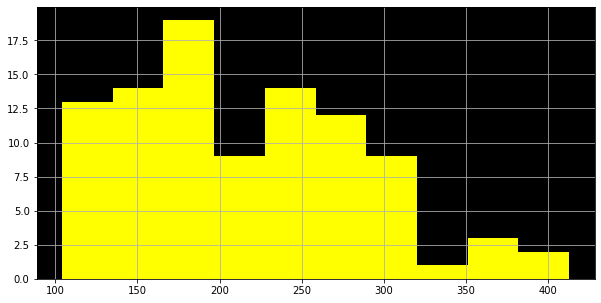

In [9]:
ax = plt.axes()
ax.set_facecolor("black")
airline['Passengers'].hist(figsize=(10,5), color = 'yellow')

<AxesSubplot:xlabel='Passengers', ylabel='Density'>

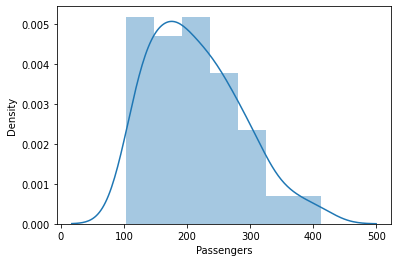

In [13]:
sns.distplot(airline['Passengers'])

#### Lagplot

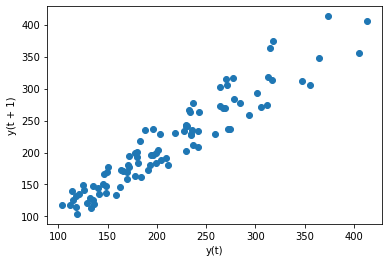

In [15]:
from pandas.plotting import lag_plot

lag_plot(airline['Passengers'])
plt.show()

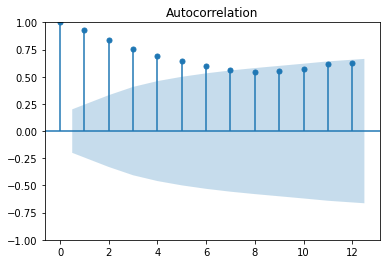

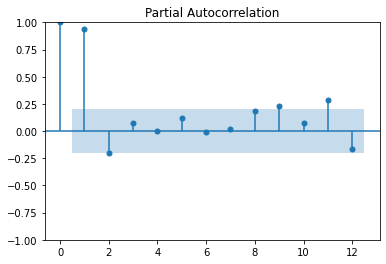

In [17]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(airline.Passengers,lags=12)
#ax = plt.axes()
#ax.set_facecolor("black")
tsa_plots.plot_pacf(airline.Passengers,lags=12)
#ax = plt.axes()
#ax.set_facecolor("white")
plt.show()

## Data Driven Forecasting Methods

In [18]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [20]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


### Moving Average Method

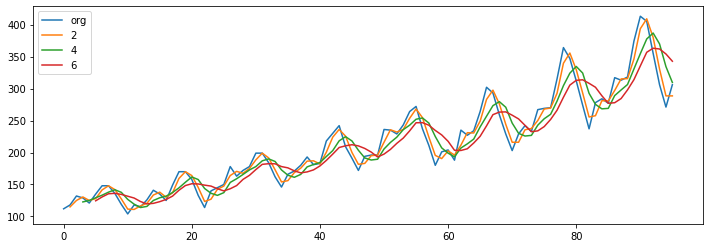

In [24]:
plt.figure(figsize=(12,4))
airline.Passengers.plot(label="org")
for i in range(2,8,2):
    airline["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

### Time series decomposition plot

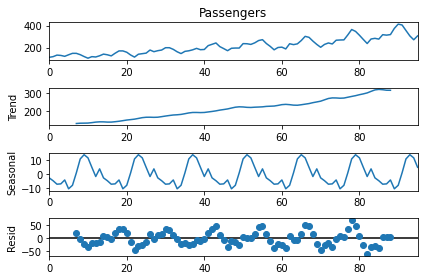

In [27]:
import statsmodels.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_ts_add=smf.tsa.seasonal_decompose(airline["Passengers"],period=14)
seasonal_ts_add.plot()
plt.show()

In [30]:
airline['Month'] = pd.to_datetime(airline['Month'])
airline['Months'] = airline['Month'].dt.strftime('%b')
airline.head()

,Month,Passengers,Months
0,1995-01-01,112,Jan
1,1995-02-01,118,Feb
2,1995-03-01,132,Mar
3,1995-04-01,129,Apr
4,1995-05-01,121,May


##### to get the dummy variables for months

In [31]:
month_dummies = pd.DataFrame(pd.get_dummies(airline['Months']))
df1 = pd.concat([airline,month_dummies],axis = 1)
df1.head()

,Month,Passengers,Months,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,Jan,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,Feb,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,Mar,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,Apr,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,May,0,0,0,0,0,0,0,0,1,0,0,0


In [32]:
df1["t"] = np.arange(1,97)       # No. of rows=96
df1["t_squared"] = df1["t"]*df1["t"]
df1["log_Passengers"] = np.log(df1["Passengers"])
df1.columns
df1.head()

,Month,Passengers,Months,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,t_squared,log_Passengers
0,1995-01-01,112,Jan,0,0,0,0,1,0,0,0,0,0,0,0,1,1,4.718499
1,1995-02-01,118,Feb,0,0,0,1,0,0,0,0,0,0,0,0,2,4,4.770685
2,1995-03-01,132,Mar,0,0,0,0,0,0,0,1,0,0,0,0,3,9,4.882802
3,1995-04-01,129,Apr,1,0,0,0,0,0,0,0,0,0,0,0,4,16,4.859812
4,1995-05-01,121,May,0,0,0,0,0,0,0,0,1,0,0,0,5,25,4.795791


### Using different models

In [34]:
Train = df1.head(84)
Test = df1.tail(12)

##### Linear Models

In [35]:
import statsmodels.formula.api as smf 
# OLS model
linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
print("RMSE Linear: ",rmse_linear)

RMSE Linear:  53.19923653480271


In [36]:
Exp = smf.ols('log_Passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
print("RMSE Exponential: ",rmse_Exp)

RMSE Exponential:  46.05736110315635


In [37]:
Quad = smf.ols('Passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
print("RMSE Quadratic: ",rmse_Quad)

RMSE Quadratic:  48.05188897933093


In [38]:
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
print("RMSE Additive seasonality: ",rmse_add_sea)

RMSE Additive seasonality:  132.81978481421814


In [39]:
add_sea_Quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))
print("RMSE Additive Seasonality Quadratic:",rmse_add_sea_quad )

RMSE Additive Seasonality Quadratic: 26.36081761209735


In [40]:
Mul_sea = smf.ols('log_Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
print("RMSE Multiplicative Seasonality:",rmse_Mult_sea)

RMSE Multiplicative Seasonality: 140.06320204708658


In [41]:
Mul_Add_sea = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
print("RMSE Multiplicative Additive Seasonality:",rmse_Mult_add_sea )

RMSE Multiplicative Additive Seasonality: 10.519172544324404


- So, RMSE is smallest for Multiplicative Additive Seasonality

In [43]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
rmse_table=pd.DataFrame(data)
rmse_table

,MODEL,RMSE_Values
0,rmse_linear,53.199237
1,rmse_Exp,46.057361
2,rmse_Quad,48.051889
3,rmse_add_sea,132.819785
4,rmse_add_sea_quad,26.360818
5,rmse_Mult_sea,140.063202
6,rmse_Mult_add_sea,10.519173


## Forecast

#### Making Dataframe of next 12 months of 2003

In [46]:
data = [['2003-01-01', 'Jan'], ['2003-02-01', 'Feb'], ['2003-03-01', 'Mar'],['2003-04-01', 'Apr'],['2003-5-01', 'May'],['2003-06-01', 'Jun'],
        ['2003-07-01', 'Jul'],['2003-08-01', 'Aug'],['2003-09-01', 'Sep'],['2003-10-01', 'Oct'],['2003-11-01', 'Nov'],['2003-12-01', 'Dec']]
forecast = pd.DataFrame(data, columns = ['Date', 'Months'])
forecast

,Date,Months
0,2003-01-01,Jan
1,2003-02-01,Feb
2,2003-03-01,Mar
3,2003-04-01,Apr
4,2003-5-01,May
5,2003-06-01,Jun
6,2003-07-01,Jul
7,2003-08-01,Aug
8,2003-09-01,Sep
9,2003-10-01,Oct


#### creating dummy variables, t, t_squared columns  to fit the model

In [48]:
dummies = pd.DataFrame(pd.get_dummies(forecast['Months']))
forecast1 = pd.concat([forecast,dummies],axis = 1)

forecast1["t"] = np.arange(1,13)   
forecast1["t_squared"] = forecast1["t"]*forecast1["t"]
print("\nAfter Dummy, T and T-Square\n\n",forecast1.head())


After Dummy, T and T-Square

          Date Months  Apr  Aug  Dec  Feb  Jan  Jul  Jun  Mar  May  Nov  Oct  \
0  2003-01-01    Jan    0    0    0    0    1    0    0    0    0    0    0   
1  2003-02-01    Feb    0    0    0    1    0    0    0    0    0    0    0   
2  2003-03-01    Mar    0    0    0    0    0    0    0    1    0    0    0   
3  2003-04-01    Apr    1    0    0    0    0    0    0    0    0    0    0   
4   2003-5-01    May    0    0    0    0    0    0    0    0    1    0    0   

   Sep  t  t_squared  
0    0  1          1  
1    0  2          4  
2    0  3          9  
3    0  4         16  
4    0  5         25  


### Forecasting using Multiplicative Additive Seasonality Model

In [49]:
model_final = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data =df1).fit()
pred_new  = pd.Series(model_final.predict(forecast1))

forecast1["Forecasted_log"] = pd.Series(pred_new)
forecast1['Forecasted_Passengers'] = np.exp(forecast1['Forecasted_log'])

## Prediction for the next 12 months

In [50]:
Final_predict = forecast1.loc[:, ['Date', 'Forecasted_Passengers']] 
Final_predict

,Date,Forecasted_Passengers
0,2003-01-01,109.176148
1,2003-02-01,110.331245
2,2003-03-01,127.315234
3,2003-04-01,123.200587
4,2003-5-01,122.399578
5,2003-06-01,138.536397
6,2003-07-01,154.066959
7,2003-08-01,153.741209
8,2003-09-01,137.693733
9,2003-10-01,120.894736
